# Objetivo del proyecto

Evaluar la robustez de modelos predictivos para detectar impagos (Default) usando Validación Cruzada Anidada.

# Obtención del dataset

Primero de todo importamos las librerías necesarias para trabajar

In [10]:
import sys
import os
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# Añadimos la carpeta raíz del proyecto al path
sys.path.append(os.path.abspath('..'))

# Ahora importamos TUS funciones
from src.preprocessing import load_data, clean_dataframe, split_features_target

In [11]:
# 1. Cargar datos (Asegúrate de que german.data esté en ../data/)
df_raw = load_data('../data/german.data')

# 2. Limpiar (Esto aplica los nombres de columnas y el mapeo de Risk 1->0, 2->1)
df_clean = clean_dataframe(df_raw)

# 3. Separar
X, y = split_features_target(df_clean, 'Risk')

print(f"Datos cargados: {X.shape}")
print(f"Distribución del Target (1=Riesgo, 0=Buen Pagador):\n{y.value_counts(normalize=True)}")

   📂 Cargando datos crudos desde: ../data/german.data
   🎯 Target 'Risk' normalizado: 1 (Bad) / 0 (Good)
      Distribución: {0: 700, 1: 300}
Datos cargados: (1000, 20)
Distribución del Target (1=Riesgo, 0=Buen Pagador):
Risk
0    0.7
1    0.3
Name: proportion, dtype: float64


In [12]:
# Identificamos columnas automáticamente (o puedes hacerlo manual si prefieres)
num_col = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_col = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numéricas:", num_col)
print("Categóricas:", cat_col)

Numéricas: ['Duration_in_month', 'Credit_amount', 'Installment_rate_in_percentage_of_disposable_income', 'Present_residence_since', 'Age_in_years', 'Number_of_existing_credits_at_this_bank', 'Number_of_people_being_liable_to_provide_maintenance_for']
Categóricas: ['Status_of_checking_account', 'Credit_history', 'Purpose', 'Savings_account_bonds', 'Present_employment_since', 'Personal_status_and_sex', 'Other_debtors_guarantors', 'Property', 'Other_installment_plans', 'Housing', 'Job', 'Telephone', 'foreign_worker']


In [13]:
# Para reproducibilidad
SEED = 42
np.random.seed(SEED)

# EDA

En esta sección vamos a analizar el dataset que vamos a utilizar. Entre otras cosas, analizaremos:
- Valores faltantes (Missings)
- Valores atípicos (Outliers)
- Valores duplicados
- Correlación entre variables

# Elección del modelo a través de validación cruzada anidada y ajuste y entrenamiento del modelo final

La validación cruzada anidada se basa en dos bucles:

El bucle interior ajusta los hiperparámetros del modelo. Una vez ajustados, se entrena el modelo con todo el conjunto de datos y se testea en el fold del bucle exterior. Esto devuelve una métrica. Repetimos el proceso tantas veces como folds hagamos en el bucle exterior. Notar dos cosas:
- El bucle interior es un GridSearchCV o un RandomizedSearchCV. Recordemos que ambos hacen una validación cruzada para el ajuste de hiperparámetros y luego entrenan el modelo final con todo el conjunto de datos y los hiperparámetros óptimos.
- La validación cruzada anidada no reporta unos hiperparámetros finales, ya que en cada fold del bucle exterior podemos obtener unos hiperparámetros distintos. Simplemente reporta una métrica fiel y honesta. Sirve también para quedarnos con un modelo, ya que la idea es hacer Nested CV con varios modelos.

Vamos a crear diccionarios donde las llaves serán los nombres de los modelos y los valores serán tuplas. El primer elemento de la tupla será el modelo y el segundo elemento será un diccionario con los hiperparámetros de dicho modelo.

In [19]:
models_config = {
    'Regresión Logística': (
        LogisticRegression(solver='liblinear', random_state=42),
        {
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__penalty': ['l1', 'l2']
        }
    ),
    'KNN': (
        KNeighborsClassifier(),
        {
            #'classifier__n_neighbors': [3, 5, 7, 9, 11],
            'classifier__weights': ['uniform', 'distance'],
            #'classifier__metric': ['euclidean', 'manhattan']
        }
    ),
    'Random Forest': (
        RandomForestClassifier(random_state=42),
        {
            'classifier__n_estimators': [50, 100, 200],
           # 'classifier__max_depth': [3, 5, 10],  # Profundidad baja para no overfittear
            #'classifier__min_samples_leaf': [2, 5] # Mínimo de muestras por hoja para generalizar
        }
    ),
    'XGBoost': (
        XGBClassifier(random_state=42, eval_metric='logloss'),
        {
            'classifier__n_estimators': [50, 100],
            #'classifier__learning_rate': [0.01, 0.1],
            #'classifier__max_depth': [3, 4, 5], # XGBoost profundo en datos pequeños es peligroso
            #'classifier__scale_pos_weight': [2.3] # Balanceo de clases (aprox 700/300)
        }
    )
}

In [ ]:
# 1. Definimos el Preprocesador Genérico
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_col),
        ('cat', cat_transformer, cat_col)
    ]
)

In [21]:
# Definimos el bucle interior de la Nested CV
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# Definimos el bucle exterior de la NestedCV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Diccionarios para guardar las puntuaciones de la Nested CV
ncv_scores={}

# Iniciamos la NCV
for model_name, (model_object, grid) in models_config.items():
    print(f'Evaluando {model_name}...')

    # Configuramos el pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model_object)
    ])

    # Configuramos el bucle interior. Este hará CV para seleccionar los mejores hiperparámetros y luego entrenará el modelo con todo el conjunto de datos
    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=grid,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1,
        #verbose=1,
        error_score='raise'
    )

    # Ejecutamos el bucle exterior. Vamos a pasar gs como nuestro estimador. 
    scores = cross_val_score(
        gs,
        X,
        y,
        cv=outer_cv,
        scoring='f1',
        n_jobs=-1,
        #verbose=1,
        error_score='raise'
    )

    # Guardamos los resultados
    ncv_scores[model_name] = scores

    # Mostramos los resultados
    print(f"Puntuaciones NCV: {np.round(scores, 4)}")
    print(f"F1 Media (Imparcial): {scores.mean():.4f} +/- {scores.std():.4f}")
    print('-'*40)


Evaluando Regresión Logística...
Puntuaciones NCV: [0.5283 0.5225 0.4952 0.5333 0.5524]
F1 Media (Imparcial): 0.5264 +/- 0.0185
----------------------------------------
Evaluando KNN...
Puntuaciones NCV: [0.3913 0.4272 0.4255 0.3448 0.6022]
F1 Media (Imparcial): 0.4382 +/- 0.0873
----------------------------------------
Evaluando Random Forest...
Puntuaciones NCV: [0.4884 0.5361 0.4835 0.4681 0.5055]
F1 Media (Imparcial): 0.4963 +/- 0.0232
----------------------------------------
Evaluando XGBoost...
Puntuaciones NCV: [0.5094 0.5421 0.5586 0.6087 0.6214]
F1 Media (Imparcial): 0.5680 +/- 0.0417
----------------------------------------


--- Resumen del Rendimiento de NCV (F1-Score) ---
XGBoost                0.568021
Regresión Logística    0.526355
Random Forest          0.496310
KNN                    0.438200
dtype: float64


       Regresión Logística       KNN  Random Forest   XGBoost
count             5.000000  5.000000       5.000000  5.000000
mean              0.526355  0.438200       0.496310  0.568021
std               0.020693  0.097569       0.025930  0.046625
min               0.495238  0.344828       0.468085  0.509434
25%               0.522523  0.391304       0.483516  0.542056
50%               0.528302  0.425532       0.488372  0.558559
75%               0.533333  0.427184       0.505495  0.608696
max               0.552381  0.602151       0.536082  0.621359


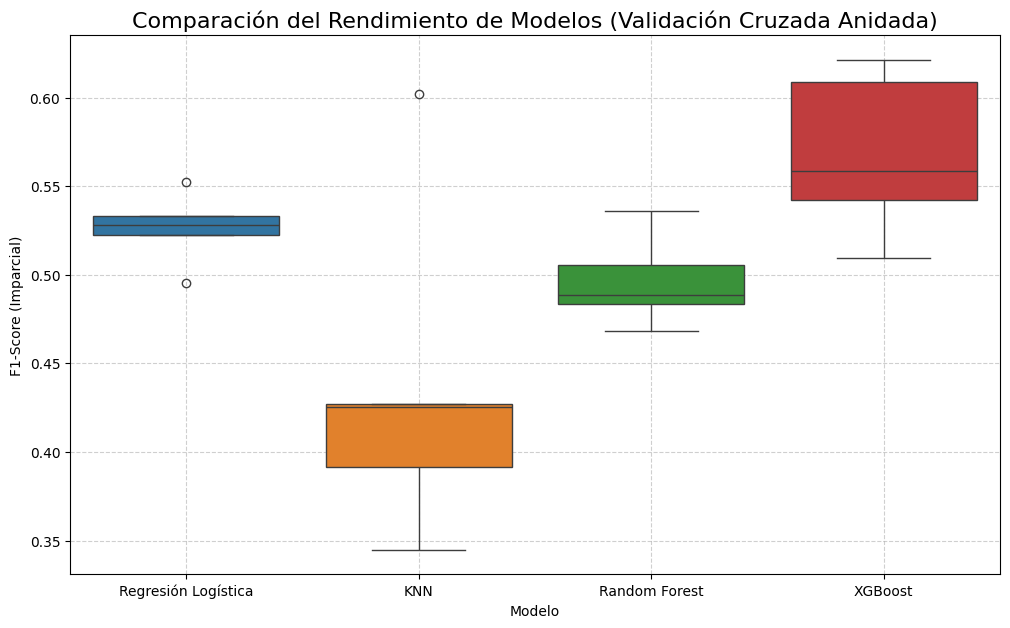

In [24]:
# Visualización de los resultados de la NCV

ncv_results_df = pd.DataFrame(ncv_scores)

# Mostrar la media y std de forma ordenada
print("--- Resumen del Rendimiento de NCV (F1-Score) ---")
print(ncv_results_df.mean().sort_values(ascending=False))
print("\n")
print(ncv_results_df.describe())

# Crear un Boxplot
plt.figure(figsize=(12, 7))
sns.boxplot(data=ncv_results_df)
plt.title('Comparación del Rendimiento de Modelos (Validación Cruzada Anidada)', fontsize=16)
plt.ylabel('F1-Score (Imparcial)')
plt.xlabel('Modelo')
plt.grid(True, linestyle='--', alpha=0.6)

# Guaradamos la imagen en la carpeta images
plt.savefig('/home/juanpe/personal/adult_income_project/images/ncv_model_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

In [26]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Asegúrate de tener estas importaciones si no las tenías arriba
from src.pipeline import get_training_pipeline

# 1. Configuración de Optuna
# Desactivamos logs verbosos para que no llene la pantalla de texto
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("🚀 Iniciando búsqueda de hiperparámetros con Optuna para XGBoost...")

def objective(trial):
    """
    Función que Optuna ejecutará muchas veces probando valores distintos.
    """
    
    # A. Definimos el ESPACIO DE BÚSQUEDA
    # Aquí le decimos: "Prueba valores entre X e Y"
    params = {
        # Número de árboles (Iteraciones)
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        
        # Profundidad de los árboles (Cuidado con valores altos -> Overfitting)
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        
        # Velocidad de aprendizaje (Logarítmico es mejor para pasos pequeños)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        
        # Parámetros para evitar overfitting (regularización)
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        
        # Balanceo de clases (Crucial para Riesgo de Crédito)
        # Prueba pesos entre 1 (sin balancear) y 5 (dar mucha importancia al fraude)
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 5.0),
        
        # Parámetros fijos (No se optimizan)
        'n_jobs': -1,
        'random_state': 42,
        'eval_metric': 'logloss'
    }
    
    # B. Construimos el Pipeline
    # Usamos las listas num_cols y cat_cols que ya definiste antes en el notebook
    pipeline = get_training_pipeline(params, num_col, cat_col)
    
    # C. Evaluamos
    # Usamos validación cruzada normal (no anidada) de 3 folds para velocidad
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Optimizamos F1-Score (importante para detectar los casos positivos/riesgo)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1', n_jobs=-1)
    
    return scores.mean()

# 2. Ejecutar el estudio
study = optuna.create_study(direction='maximize') # Queremos maximizar F1
study.optimize(objective, n_trials=30) # 30 intentos (puedes subirlo a 50 o 100 si tienes tiempo)

# 3. Mostrar resultados
print("-" * 60)
print(f"🏆 MEJOR F1-SCORE: {study.best_value:.4f}")
print("-" * 60)
print("⚙️  MEJORES HIPERPARÁMETROS (Cópialos a config.yaml):")
print(study.best_params)

🚀 Iniciando búsqueda de hiperparámetros con Optuna para XGBoost...


------------------------------------------------------------
🏆 MEJOR F1-SCORE: 0.5988
------------------------------------------------------------
⚙️  MEJORES HIPERPARÁMETROS (Cópialos a config.yaml):
{'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.11867847060421036, 'subsample': 0.7212304279769838, 'colsample_bytree': 0.7781334880061416, 'gamma': 4.147876495966024, 'scale_pos_weight': 4.798309497274321}
